# Fitting a rod scattering spectra to classical dipole scattering of a polarizable prolate ellipsoid 

In [1]:
import numpy as np
import scipy.optimize as opt
import scipy.io as sio
import scipy.constants as con

# import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
nm = 1e-7

In [5]:
## load matlab spectra with 
## sio.loadmat('fields_from_BEM')
long_path_to_spectra = '/Users/chair/Documents/MATLAB/100918/curly_rod_spectra'
tran_path_to_spectra = '/Users/chair/Documents/MATLAB/100918/curly_rod_trans_spectra_1'

loaded_spectra = sio.loadmat(long_path_to_spectra)
loaded_trans_spec = sio.loadmat(tran_path_to_spectra)


In [6]:
# loaded_spectra.keys()
loaded_spectra['long_mode'].shape

(200, 3)

In [7]:
np.all(loaded_spectra['long_mode'][:,1]==loaded_spectra['long_mode'][:,2])

True

In [8]:
long_sigma = loaded_spectra['long_mode'][:,1]*(1e-14) ## cm^2/nm^2
trans_sigma = loaded_trans_spec['trans_mode'][:,1]*(1e-14)

long_lambdas = loaded_spectra['long_mode'][:,0]
trans_lambdas = loaded_trans_spec['trans_mode'][:,0]

long_hbarws = hbar*c*2*np.pi/(long_lambdas*1e-7) 
trans_hbarws = hbar*c*2*np.pi/(trans_lambdas*1e-7) 


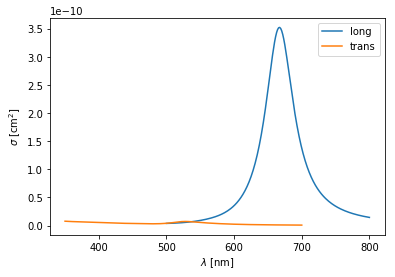

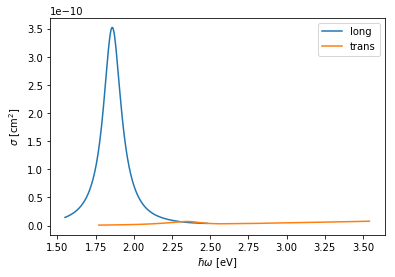

In [9]:
plt.plot(long_lambdas,long_sigma, label='long')
plt.plot(trans_lambdas,trans_sigma, label='trans')
plt.xlabel(r'$\lambda$ [nm]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.legend()

plt.figure()
plt.plot(long_hbarws,long_sigma, label='long')
plt.plot(trans_hbarws,trans_sigma, label='trans')
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.legend()


plotting spectra and getting oriented...

In [10]:
import coupled_dipoles as cp

reading parameters from ../curly_param.yaml
polarizability reduced by factor of 1
coupling scaled up by by factor of 1


In [11]:
a_x = 44*nm
a_y = 20*nm
a_z = 20*nm
def fit_scat_1(hbarw, eps_inf, w_p, gamma):
    return cp.sigma_scat_spheroid(hbarw/hbar, eps_inf, w_p, gamma, 1., a_x, a_y, a_z)
def fit_scat_2(hbarw, eps_inf, w_p, gamma):
    return cp.sigma_scat_spheroid(hbarw/hbar, eps_inf, w_p, gamma, 1., a_y, a_x, a_z)

In [12]:
ini_guess = [10, 9/hbar, 0.06/hbar]
popt, pcov = opt.curve_fit(
            fit_scat_1,
            long_hbarws, 
            long_sigma,
            p0=ini_guess
            )

/Users/chair/anaconda/envs/py37/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


testing fit one mode at a time like I did in old code...

In [13]:
popt

array([-6.91232692e+00,  2.51622248e+10,  1.63518501e+15])

In [14]:
ini_guess

[10, 1.367340714621974e+16, 91156047641464.94]

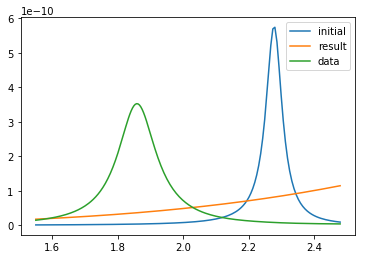

In [15]:
# plt.plot(long_hbarws, fit_scat_1(long_hbarws, *popt))
plt.plot(long_hbarws, fit_scat_1(long_hbarws, *ini_guess),label='initial')
plt.plot(long_hbarws, fit_scat_1(long_hbarws, *popt),label='result')
plt.plot(long_hbarws,long_sigma,label='data')
plt.legend()

fits pretty well to long mode in isolation with just Drude fit parameters: [$\epsilon_\inf$, $\hbar \omega_p$, $\hbar\gamma_\mathrm{NR}$]

In [16]:
fit_eps_inf_1 = popt[0]
fit_hbar_wp_1 = popt[1]*hbar
fit_hbar_gamma_1 = popt[2]*hbar
[fit_eps_inf_1, fit_hbar_wp_1, fit_hbar_gamma_1]

[-6.912326922331704, 1.6562077083255057e-05, 1.07629831507178]

In [17]:
ini_guess_2 = [.77, 3.3/hbar, 0.9/hbar]
popt_2, pcov_2 = opt.curve_fit(
            fit_scat_2,
            trans_hbarws, 
            trans_sigma,
            p0=ini_guess_2
            )

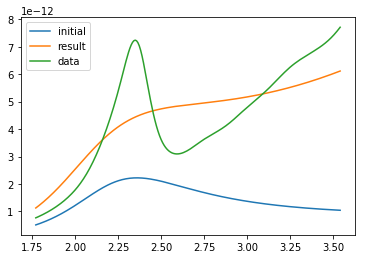

In [18]:
plt.plot(trans_hbarws, fit_scat_2(trans_hbarws, *ini_guess_2),label='initial')
plt.plot(trans_hbarws, fit_scat_2(trans_hbarws, *popt_2),label='result')
plt.plot(trans_hbarws,trans_sigma,label='data')
plt.legend()

short mode has more trouble because of high energy nonsense, I assume this is interband stuff kicking in. Will avoid this by truncating spectra at local minimum. 

Thinking in retrospect that this might be a litte weird because the peak wil still be artificially widented and blue shifted by the underlying tail of high energy stuff. 

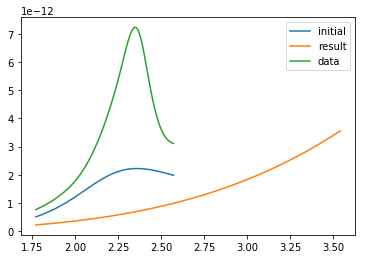

In [19]:
plt.plot(trans_hbarws[75:], fit_scat_2(trans_hbarws[75:], *ini_guess_2),label='initial')
plt.plot(trans_hbarws, fit_scat_2(trans_hbarws, *popt),label='result')
plt.plot(trans_hbarws[75:],trans_sigma[75:],label='data')
plt.legend()

In [20]:
ini_guess_2 = [.77, 3.3/hbar, 0.4/hbar]
popt_2, pcov_2 = opt.curve_fit(
            fit_scat_2,
            trans_hbarws[75:], 
            trans_sigma[75:],
            p0=ini_guess_2
            )

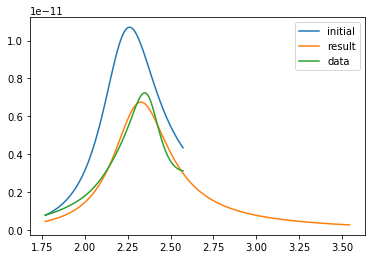

In [21]:
plt.plot(trans_hbarws[75:], fit_scat_2(trans_hbarws[75:], *ini_guess_2), label='initial')
plt.plot(trans_hbarws, fit_scat_2(trans_hbarws, *popt_2), label='result')
plt.plot(trans_hbarws[75:],trans_sigma[75:], label='data')
plt.legend()

And not suprisingly it doesnt work too well, probably because of the interband-induced overlap broadening. But this doesnt really make sense considering that the fit-result is broader then the data.  

Its interesting that the lowest energy point did not change energy from initial condition (blue) to fit result (orange) while the data falls at low energy.

In [22]:
popt_2

array([1.62590557e+00, 6.12973191e+15, 6.06968548e+14])

In [23]:
fit_eps_inf_2 = popt_2[0]
fit_hbar_wp_2 = popt_2[1]*hbar
fit_hbar_gamma_2 = popt_2[2]*hbar
[fit_eps_inf_2, fit_hbar_wp_2, fit_hbar_gamma_2]

[1.6259055687109512, 4.034662800280863, 0.39951395209033086]

In [24]:
[fit_eps_inf_1, fit_hbar_wp_1, fit_hbar_gamma_1]

[-6.912326922331704, 1.6562077083255057e-05, 1.07629831507178]

In [25]:
trans_hbarws[75:]

array([2.57276906, 2.56341354, 2.55412581, 2.54490513, 2.5357508 ,
       2.52666209, 2.51763829, 2.50867873, 2.4997827 , 2.49094955,
       2.4821786 , 2.4734692 , 2.46482071, 2.45623248, 2.4477039 ,
       2.43923433, 2.43082318, 2.42246984, 2.41417371, 2.40593421,
       2.39775076, 2.38962279, 2.38154974, 2.37353105, 2.36556618,
       2.35765459, 2.34979574, 2.34198911, 2.33423418, 2.32653044,
       2.31887738, 2.3112745 , 2.30372131, 2.29621734, 2.28876209,
       2.28135509, 2.27399588, 2.26668399, 2.25941898, 2.25220039,
       2.24502778, 2.23790071, 2.23081874, 2.22378146, 2.21678843,
       2.20983925, 2.20293351, 2.19607079, 2.18925069, 2.18247282,
       2.1757368 , 2.16904222, 2.16238872, 2.15577591, 2.14920342,
       2.14267089, 2.13617795, 2.12972424, 2.1233094 , 2.1169331 ,
       2.11059498, 2.10429469, 2.09803191, 2.0918063 , 2.08561752,
       2.07946526, 2.07334918, 2.06726898, 2.06122433, 2.05521493,
       2.04924047, 2.04330064, 2.03739515, 2.0315237 , 2.02568

In [26]:
(long_hbarws[0]/(hbar*c))**4.

2.4936727304704632e+20

In [27]:
cp.sigma_scat_spheroid(long_hbarws[0]/hbar, *ini_guess, 1., a_x, a_y, a_z)

9.053949263977871e-12

In [28]:
def L_i(a, b, c):
    ''' assumes 'a' is ith radius for 'L_i' '''
    q = np.linspace(0,1000000,100000)*nm**2.
    fq = ( (a**2. + q) * (b**2. + q) * (c**2. + q) )**0.5
    integrand = 1/( (a**2. + q) * fq )
    integral = np.trapz(integrand, q)
    L_val = (a*b*c/2) * integral
    print('L_val= ',L_val)
    return L_val

In [29]:
L_i(a_x,a_y,a_z)

L_val=  0.15632699551507445


0.15632699551507445

# Moving into simultaneous fitting of long + trans modes

In [30]:
np.hstack(([1,2],[2,3]))

array([1, 2, 2, 3])

In [31]:
combined_fit_x = np.hstack((long_hbarws,trans_hbarws[75:]))
combined_fit_y = np.hstack((long_sigma,trans_sigma[75:]))

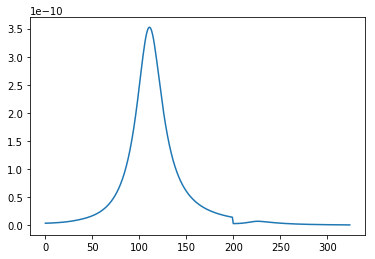

In [32]:
plt.plot(combined_fit_y)

### allowing ($\epsilon_\inf$,$\hbar\omega_p$, $\hbar\gamma_\mathrm{NR}$, $a_1$, $a_2$) to vary as fit parameters

In [33]:
import math
#+++++++++++++++++++++++++++++++++++++++++++++
a_x = 44*nm
a_y = 20*nm
a_z = 20*nm
def fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.sigma_scat_spheroid(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm, a_2*nm)*1e10
def fit_scat_2(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.sigma_scat_spheroid(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_2*nm, a_1*nm, a_2*nm)*1e10
#+++++++++++++++++++++++++++++++++++++++++++++

def leastsq_func(params, *args):
    x1=args[0]
    x2=args[1]
    y1=args[2]*1e10
    y2=args[3]*1e10
    y = np.hstack((y1,y2))
#     data=args[2:]

    eps_inf=params[0]
    w_p=params[1]
    gamma=params[2]
    a1 =params[3]
    a2 = params[4]
    
    cc = 2
#     print(x.shape)
#     incs = np.shape(x[0])[0]
    yfit=np.empty(np.hstack((y1,y2)).shape)
    for i in range(cc):
        if i==0:
            yfit[:x1.shape[0]]=fit_scat_1(x1,*params)
        elif i==1:
            yfit[x1.shape[0]:]=fit_scat_2(x2,*params)
    return y-yfit
#+++++++++++++++++++++++++++++++++++++++++++++
# Ts  =[10,100,1000,10000]    #4 T-values for 4 curves
# incs=10                     #10 datapoints in each curve
x1 = long_hbarws
x2 = trans_hbarws[75:]
y1 = long_sigma
y2 = trans_sigma[75:]

ini_guess_both=np.array([4,6, 0.6, 44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[x1,x2,y1,y2]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(leastsq_func, params0,ftol=1e-12, args=args)

In [34]:
result['x']

array([ 9.42643762,  8.55546791, -0.14277597, 66.87575871, 18.10102798])

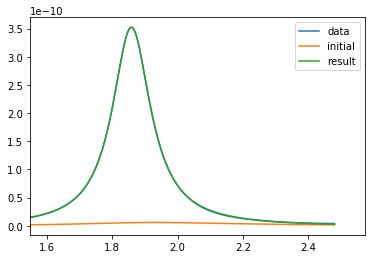

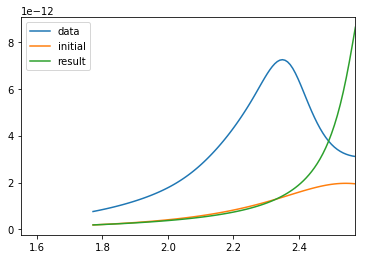

In [35]:
plt.plot(x1,y1,label='data')
plt.plot(x1,fit_scat_1(x1,*ini_guess_both)*1e-10,label='initial')
plt.plot(x1,fit_scat_1(x1,*result['x'])*1e-10,label='result')
plt.xlim([np.min(x1),np.max(x2)])
plt.legend()

plt.figure()
plt.plot(x2,y2,label='data')
plt.plot(x2,fit_scat_2(x2,*ini_guess_both)*1e-10,label='initial')
plt.plot(x2,fit_scat_2(x2,*result['x'])*1e-10,label='result')
plt.xlim([np.min(x1),np.max(x2)])
plt.legend()

fit converges to both long and trans peaks biased towards long peak data. 
Seems like without radiation damping the short and long axis modes will be too close. This is consistent with sphere intuition that the radius does not shift the peak resonance energy with in the QS limit.

## Moving to a retardation-corrected model of the prolate spheroid polarizability as proscribed by Kong's notes. 

In [36]:
import numpy as np
import scipy.optimize as opt
import scipy.io as sio
import scipy.constants as con

# import matplotlib as mpl
import matplotlib.pyplot as plt

hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
nm = 1e-7

import coupled_dipoles as cp

nm = 1e-7
a_x = 44*nm
a_y = 20*nm
a_z = 20*nm
cp.long_sigma_scat_ret_pro_ellip(2.0/hbar, 10, 9/hbar, 0.06/hbar, 1., a_x*nm,a_y*nm)

In [37]:
nm = 1e-7
a_x = 44*nm
a_y = 20*nm
a_z = 20*nm
cp.long_sigma_scat_ret_pro_ellip(2.0/hbar, 10, 9/hbar, 0.06/hbar, 1., a_x*nm,a_y*nm)

6.634585361724064e-54

In [38]:
cp.sigma_scat_spheroid(2.0/hbar, 10, 9/hbar, 0.06/hbar, 1., a_x*nm, a_y*nm, a_z*nm)


1.8247255373495814e-74

In [52]:
def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.long_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10
def ret_fit_scat_2(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.short_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10
#+++++++++++++++++++++++++++++++++++++++++++++

def ret_leastsq_func(params, *args):
    x1=args[0]
    x2=args[1]
    y1=args[2]*1e10
    y2=args[3]*1e10
    y = np.hstack((y1,y2))
#     data=args[2:]

    eps_inf=params[0]
    w_p=params[1]
    gamma=params[2]
    a1 =params[3]
    a2 = params[4]
    
    cc = 2
#     print(x.shape)
#     incs = np.shape(x[0])[0]
    yfit=np.empty(np.hstack((y1,y2)).shape)
    for i in range(cc):
        if i==0:
            yfit[:x1.shape[0]]=ret_fit_scat_1(x1,*params)
        elif i==1:
            yfit[x1.shape[0]:]=ret_fit_scat_2(x2,*params)
    return y-yfit


#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([9.8, 9, 0.07, 44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[x1,x2,y1,y2]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(ret_leastsq_func, params0, ftol=1e-15,xtol=1e-15, gtol=1e-15, args=args)

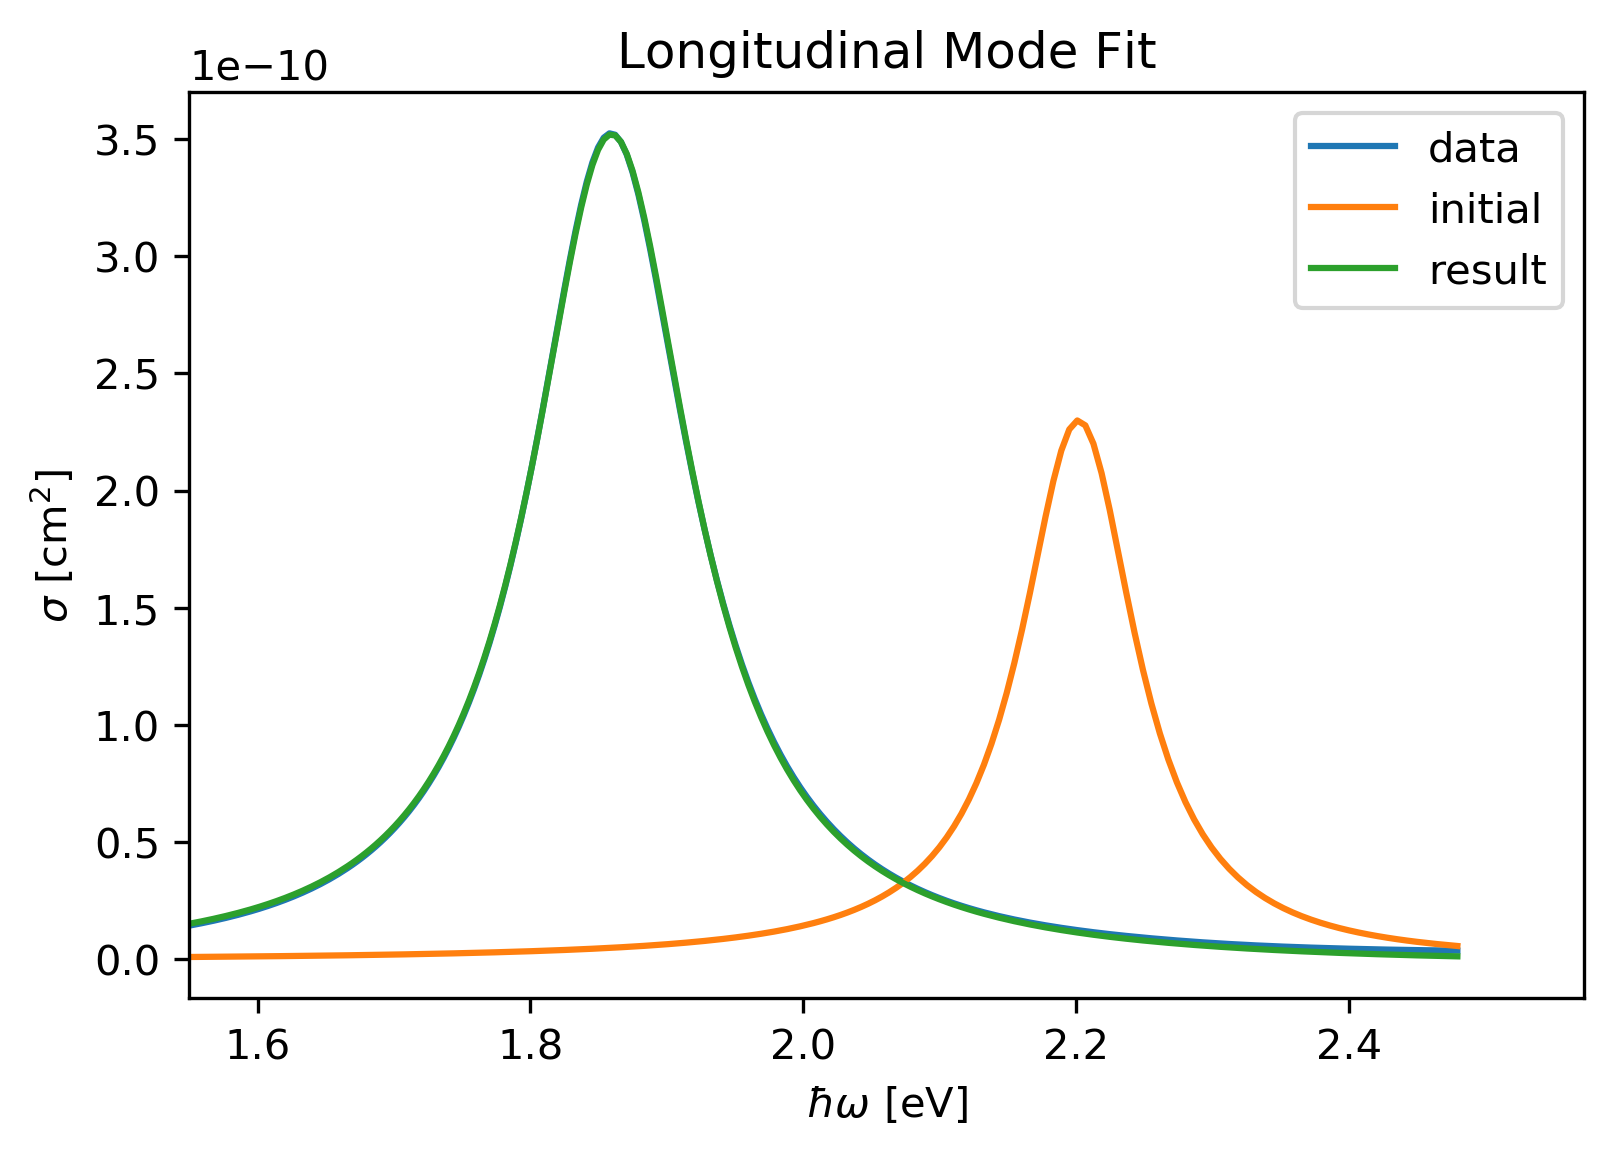

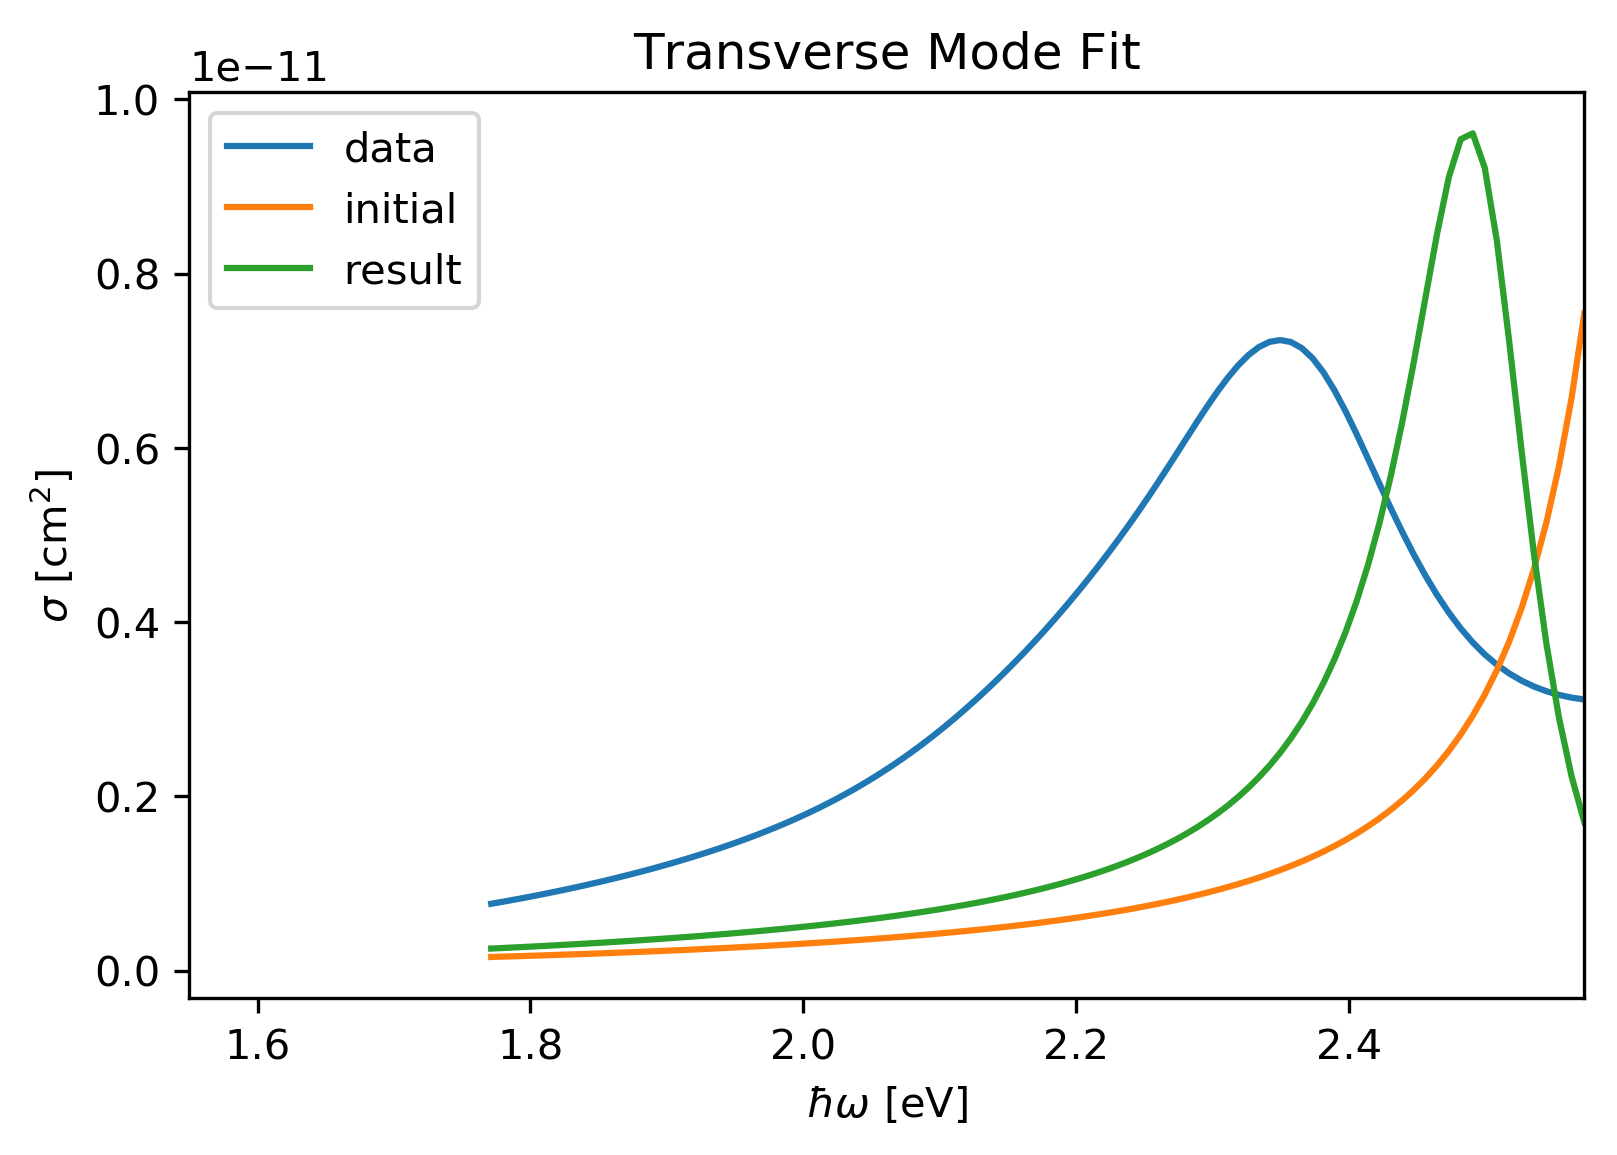

In [58]:
def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.long_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10
def ret_fit_scat_2(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.short_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10

plt.figure(dpi=300)
plt.plot(x1,y1,label='data')
plt.plot(x1,ret_fit_scat_1(x1,*ini_guess_both)*1e-10,label='initial')
plt.plot(x1,ret_fit_scat_1(x1,*result['x'])*1e-10,label='result')
plt.xlim([np.min(x1),np.max(x2)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Longitudinal Mode Fit')
plt.legend()

plt.figure(dpi=300)
plt.plot(x2,y2,label='data')
plt.plot(x2,ret_fit_scat_2(x2,*ini_guess_both)*1e-10,label='initial')
plt.plot(x2,ret_fit_scat_2(x2,*result['x'])*1e-10,label='result')
plt.xlim([np.min(x1),np.max(x2)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Transverse Mode Fit')
plt.legend()

In [54]:
result['x']

array([15.100176  , 10.15232758,  0.10316881, 67.24906658, 19.20816015])

In [42]:
ini_guess_both

array([ 9.8 ,  9.  ,  0.07, 44.  , 20.  ])

In [43]:
x1[np.argmax(y1)]

1.8578957289256757

Going to try fixing drude parameters to something reasonable and fitting radii

In [44]:
eps_inf = 9.8
hbarw_p = 9
hbargamma = 0.07
def ret_fit_scat_1(hbarw, a_1, a_2):
    return cp.long_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10
def ret_fit_scat_2(hbarw,  a_1, a_2):
    return cp.short_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10
#+++++++++++++++++++++++++++++++++++++++++++++

def ret_leastsq_func(params, *args):
    x1=args[0]
    x2=args[1]
    y1=args[2]*1e10
    y2=args[3]*1e10
    y = np.hstack((y1,y2))
#     data=args[2:]

    a1 =params[0]
    a2 = params[1]
    
    cc = 2
#     print(x.shape)
#     incs = np.shape(x[0])[0]
    yfit=np.empty(np.hstack((y1,y2)).shape)
    for i in range(cc):
        if i==0:
            yfit[:x1.shape[0]]=ret_fit_scat_1(x1,*params)
        elif i==1:
            yfit[x1.shape[0]:]=ret_fit_scat_2(x2,*params)
    return y-yfit


#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[x1,x2,y1,y2]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(ret_leastsq_func, params0, ftol=1e-15,xtol=1e-15, gtol=1e-15, args=args)

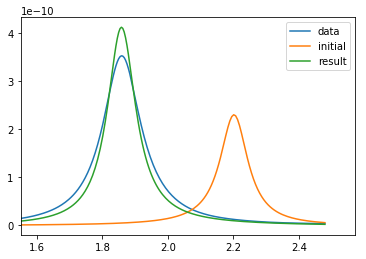

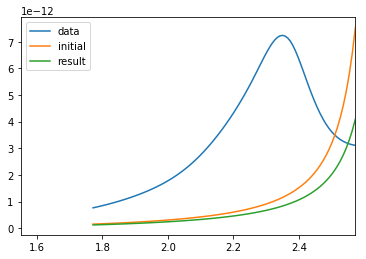

In [45]:
plt.plot(x1,y1,label='data')
plt.plot(x1,ret_fit_scat_1(x1,*ini_guess_both)*1e-10,label='initial')
plt.plot(x1,ret_fit_scat_1(x1,*result['x'])*1e-10,label='result')
plt.xlim([np.min(x1),np.max(x2)])
plt.legend()

plt.figure()
plt.plot(x2,y2,label='data')
plt.plot(x2,ret_fit_scat_2(x2,*ini_guess_both)*1e-10,label='initial')
plt.plot(x2,ret_fit_scat_2(x2,*result['x'])*1e-10,label='result')
plt.xlim([np.min(x1),np.max(x2)])
plt.legend()

In [46]:
result['x']

array([60.19836257, 17.01576097])

well that is significantly worse.... 

Think i need to go back and fit a Drude simulation to check and make sure my fitting is working propertly and rule out any issues with what I have coded. 

Realized that I had the background $\epsilon$ set to 1.778 in simulation, so I'll try that real quick

In [47]:
eps_b = 1.778
def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.long_sigma_scat_ret_pro_ellip( hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, eps_b, a_1*nm, a_2*nm)*1e10
def ret_fit_scat_2(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.short_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, eps_b, a_1*nm, a_2*nm)*1e10
#+++++++++++++++++++++++++++++++++++++++++++++

def ret_leastsq_func(params, *args):
    x1=args[0]
    x2=args[1]
    y1=args[2]*1e10
    y2=args[3]*1e10
    y = np.hstack((y1,y2))
#     data=args[2:]

    eps_inf=params[0]
    w_p=params[1]
    gamma=params[2]
    a1 =params[3]
    a2 = params[4]
    
    cc = 2
#     print(x.shape)
#     incs = np.shape(x[0])[0]
    yfit=np.empty(np.hstack((y1,y2)).shape)
    for i in range(cc):
        if i==0:
            yfit[:x1.shape[0]]=ret_fit_scat_1(x1,*params)
        elif i==1:
            yfit[x1.shape[0]:]=ret_fit_scat_2(x2,*params)
    return y-yfit


#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([9.8, 9, 0.07, 44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[x1,x2,y1,y2]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    ret_leastsq_func, params0, ftol=1e-15,xtol=1e-15, gtol=1e-15,
#     bounds=(0,np.inf), 
    args=args)

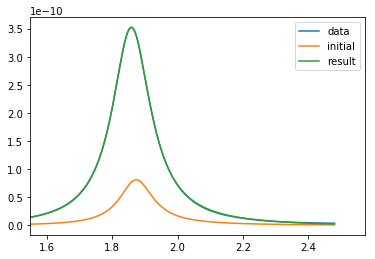

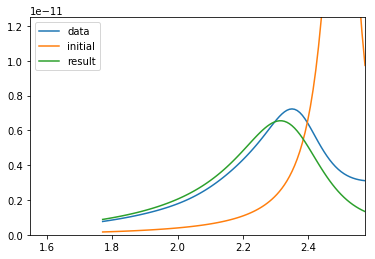

In [48]:
plt.plot(x1,y1,label='data')
plt.plot(x1,ret_fit_scat_1(x1,*ini_guess_both)*1e-10,label='initial')
plt.plot(x1,ret_fit_scat_1(x1,*result['x'])*1e-10,label='result')
plt.xlim([np.min(x1),np.max(x2)])
plt.legend()

plt.figure()
plt.plot(x2,y2,label='data')
plt.plot(x2,ret_fit_scat_2(x2,*ini_guess_both)*1e-10,label='initial')
plt.plot(x2,ret_fit_scat_2(x2,*result['x'])*1e-10,label='result')
plt.xlim([np.min(x1),np.max(x2)])
plt.ylim([0.0,0.125*1e-10])
plt.legend()

In [49]:
result['x']

array([22.29725838, 11.94159261, -0.40753147, 61.14007733, 26.53110913])

that negative doesnt make any sense. Something is wrong here. 

# 01/24/19: Fitting the rod in vacuum 

In [40]:
import numpy as np
import scipy.optimize as opt
import scipy.io as sio
import scipy.constants as con

# import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook

hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
nm = 1e-7

import coupled_dipoles as cp

nm = 1e-7
a_x = 44*nm
a_y = 20*nm
a_z = 20*nm
# cp.long_sigma_scat_ret_pro_ellip(2.0/hbar, 10, 9/hbar, 0.06/hbar, 1., a_x*nm, a_y*nm)

In [41]:
spectra_file_name = 'curly_rod_spectra_AuDrude_epsb1p0.mat'
## load matlab spectra with 
## sio.loadmat('fields_from_BEM')
path_to_spectra = '/Users/chair/Documents/MATLAB/012419/' + spectra_file_name

loaded_spectra = sio.loadmat(path_to_spectra)



In [42]:
loaded_spectra.keys()

dict_keys(['__header__', '__version__', '__globals__', 'long_mode', 'trans_mode'])

In [43]:
loaded_spectra['long_mode'].shape

(150, 3)

In [44]:
long_sigma = loaded_spectra['long_mode'][:,1]*(1e-14) ## cm^2/nm^2
trans_sigma = loaded_spectra['trans_mode'][:,1]*(1e-14)

long_lambdas = loaded_spectra['long_mode'][:,0]
trans_lambdas = loaded_spectra['trans_mode'][:,0]

long_hbarws = 1240/long_lambdas
trans_hbarws = 1240/trans_lambdas

In [129]:
def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.long_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10
def ret_fit_scat_2(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
    return cp.short_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, 1., a_1*nm, a_2*nm)*1e10

#+++++++++++++++++++++++++++++++++++++++++++++

def ret_leastsq_func(params, *args):
    x1=args[0]
    x2=args[1]
    y1=args[2]*1e10
    y2=args[3]*1e10
    y = np.hstack((y1,y2))
#     data=args[2:]

    eps_inf=params[0]
    w_p=params[1]
    gamma=params[2]
    a1 =params[3]
    a2 = params[4]
    
    cc = 2
#     print(x.shape)
#     incs = np.shape(x[0])[0]
    yfit=np.empty(np.hstack((y1,y2)).shape)
    for i in range(cc):
        if i==0:
            yfit[:x1.shape[0]]=ret_fit_scat_1(x1,*params)
        elif i==1:
            yfit[x1.shape[0]:]=ret_fit_scat_2(x2,*params)
    return y-yfit


#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([9.8, 9, 0.07, 44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[long_hbarws, trans_hbarws, long_sigma, trans_sigma]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(ret_leastsq_func, params0, ftol=1e-15,xtol=1e-15, gtol=1e-15, args=args)

<IPython.core.display.Javascript object>


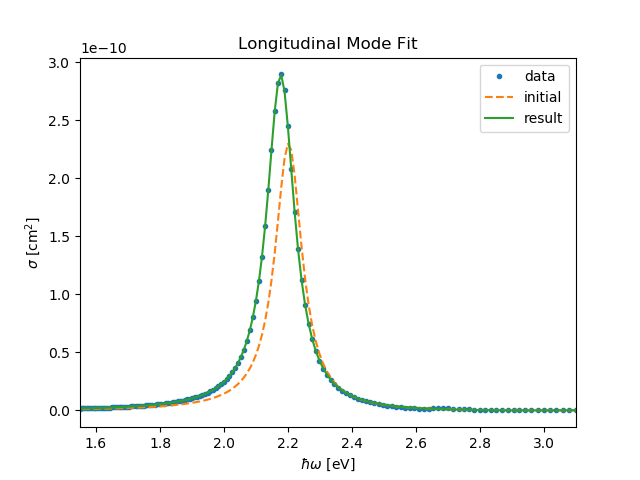

<IPython.core.display.Javascript object>


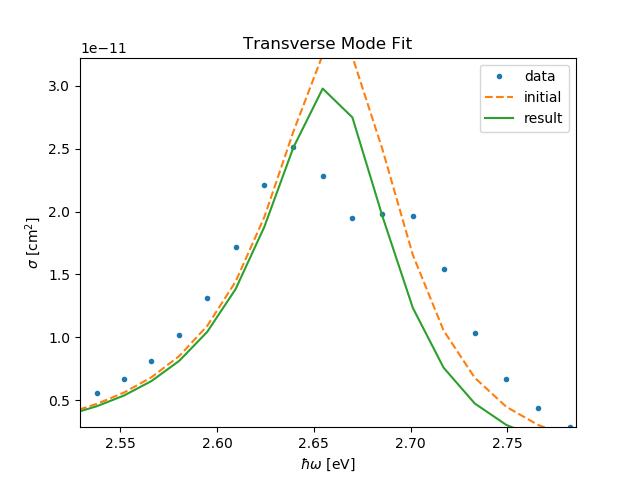

In [130]:
plt.figure(dpi=100)
plt.plot(long_hbarws, long_sigma, label='data', ls=' ', marker='.')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *ini_guess_both)*1e-10,label='initial', ls='--')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *result['x'])*1e-10,label='result', ls='-')
plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Longitudinal Mode Fit')
plt.legend()

plt.figure(dpi=100)
plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both)*1e-10, label='initial', ls='--')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Transverse Mode Fit')
plt.legend()

In [21]:
result['x']

array([11.59368545,  9.65413422,  0.06807553, 48.04291551, 19.93376247])

Old result was 

``array([15.100176  , 10.15232758,  0.10316881, 67.24906658, 19.20816015])``

where the fit values correspond to 

``[eps_inf, hbarw_p, hbargamma, a_1, a_2]``

Doing better on the radii, let me go check the BEM Drude params

From MNPBEM source file ``'MNPBEM/Material/@epsdrude/init.m'``

```Matlab
function obj = init( obj )
%  Initialize Drude dielectric function.

%  atomic units
hartree = 27.2116;              %  2 * Rydberg in eV
tunit = 0.66 / hartree;         %  time unit in fs

switch obj.name
  case { 'gold_eps_inf_to_1' }  
    rs = 3;                     %  electron gas parameter
    obj.eps0 = 1;              %  background dielectric constant
    gammad = tunit / 10;        %  Drude relaxation rate
  case { 'Au', 'gold' }
    rs = 3;                     %  electron gas parameter
    obj.eps0 = 10;              %  background dielectric constant
    gammad = tunit / 10;        %  Drude relaxation rate
  case { 'Ag', 'silver' }
    rs = 3;
    obj.eps0 = 3.3;
    gammad = tunit / 30;
  case { 'Al', 'aluminum' }
    rs = 2.07;
    obj.eps0 = 1;
    gammad = 1.06 / hartree;
  otherwise
    error( 'Material name unknown' );
end

%  density in atomic units
density = 3 / ( 4 * pi * rs ^ 3 );
%  plasmon energy
wp = sqrt( 4 * pi * density );

%  save values
obj.gammad = gammad * hartree;
obj.wp     = wp     * hartree;

    
```

Calculating values

In [108]:
hartree = 27.2116
tunit = 0.66 / hartree

rs = 3
eps0 = 10
gammad = tunit / 10 * hartree

In [109]:
density = 3 / ( 4 * np.pi * rs**3 )
wp = np.sqrt( 4 * np.pi * density )* hartree

In [110]:
print("gammad = ", gammad)
print("eps0 = ", eps0)
print("wp = ", wp)

gammad =  0.066
eps0 =  10
wp =  9.070533333333335


So I did suprisingly well. 

In [111]:
param_str_list = ['eps_inf', 'hbarw_p', 'hbargamma', 'a_1', 'a_2']

new_fit_results=dict(zip(param_str_list, result['x']))
print(f"new_fit_results = {new_fit_results}",'\n')
old_fit_result_list = np.array([15.100176  , 10.15232758,  0.10316881, 67.24906658, 19.20816015])
old_fit_results = dict(zip(param_str_list, old_fit_result_list))
print(f"old_fit_results = {old_fit_results}")


new_fit_results = {'eps_inf': 11.593685450998338, 'hbarw_p': 9.65413421804693, 'hbargamma': 0.06807552712549593, 'a_1': 48.042915506229754, 'a_2': 19.93376246540251} 

old_fit_results = {'eps_inf': 15.100176, 'hbarw_p': 10.15232758, 'hbargamma': 0.10316881, 'a_1': 67.24906658, 'a_2': 19.20816015}


## Wondering if I can do better by avoiding the second trans peak
---
Dip appears at $\hbar\omega = 2.670$

In [112]:
index_to_267 = np.where(trans_hbarws<2.67)
index_to_267

(array([ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
         37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
         50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149]),)

In [113]:
trans_hbarws[index_to_267]

array([2.6699422 , 2.6545977 , 2.63942857, 2.62443182, 2.60960452,
       2.59494382, 2.58044693, 2.56611111, 2.5519337 , 2.53791209,
       2.52404372, 2.51032609, 2.49675676, 2.48333333, 2.47005348,
       2.45691489, 2.44391534, 2.43105263, 2.41832461, 2.40572917,
       2.39326425, 2.38092784, 2.36871795, 2.35663265, 2.34467005,
       2.33282828, 2.32110553, 2.3095    , 2.29800995, 2.28663366,
       2.27536946, 2.26421569, 2.25317073, 2.24223301, 2.23140097,
       2.22067308, 2.21004785, 2.19952381, 2.18909953, 2.17877358,
       2.1685446 , 2.15841121, 2.14837209, 2.13842593, 2.12857143,
       2.11880734, 2.10913242, 2.09954545, 2.09004525, 2.08063063,
       2.07130045, 2.06205357, 2.05288889, 2.04380531, 2.03480176,
       2.02587719, 2.01703057, 2.00826087, 1.9995671 , 1.99094828,
       1.98240343, 1.97393162, 1.96553191, 1.95720339, 1.94894515,
       1.9407563 , 1.93263598, 1.92458333, 1.91659751, 1.90867769,
       1.90082305, 1.89303279, 1.88530612, 1.87764228, 1.87004

In [119]:

ini_guess_both=np.array([11, 9, 0.07, 44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[long_hbarws, trans_hbarws[index_to_267], long_sigma, trans_sigma[index_to_267]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

no_trans_quad_result=opt.least_squares(ret_leastsq_func, params0, ftol=1e-15,xtol=1e-15, gtol=1e-15, args=args)

<IPython.core.display.Javascript object>


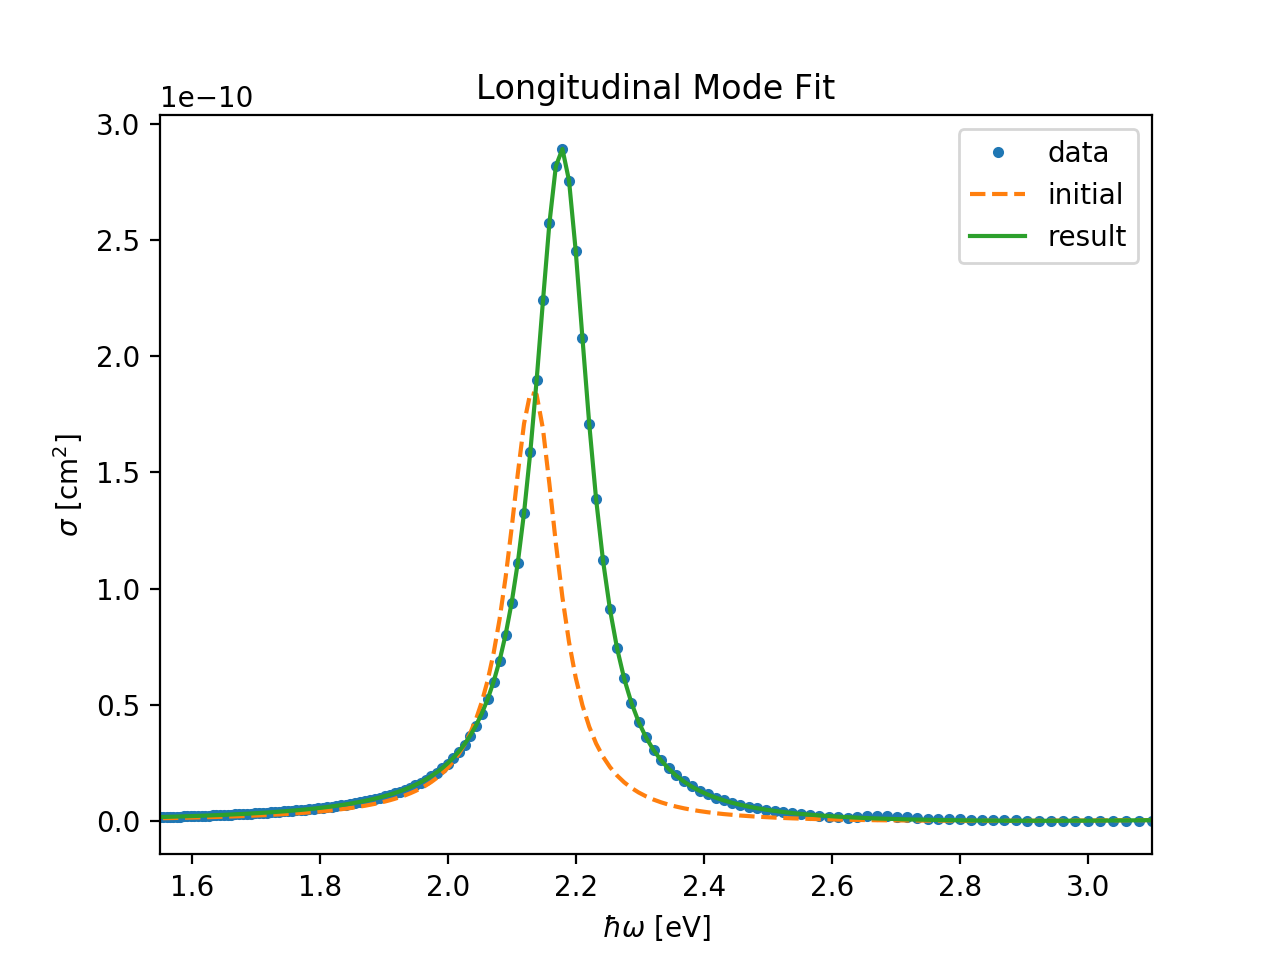

<IPython.core.display.Javascript object>


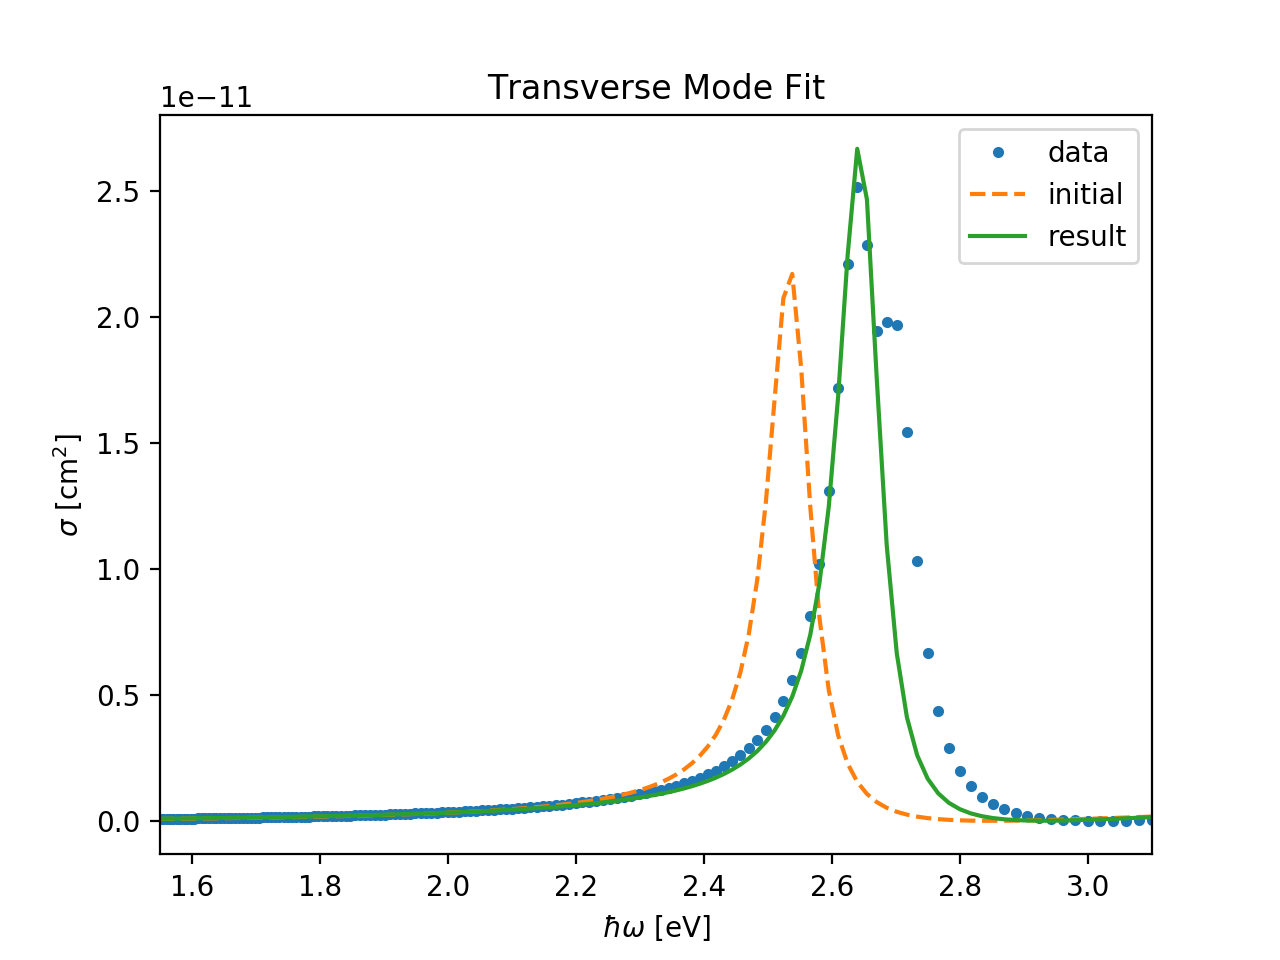

In [120]:
plt.figure(dpi=100)
plt.plot(long_hbarws, long_sigma, label='data', ls=' ', marker='.')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *ini_guess_both)*1e-10,label='initial', ls='--')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *no_trans_quad_result['x'])*1e-10,label='result', ls='-')
plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Longitudinal Mode Fit')
plt.legend()

plt.figure(dpi=100)
plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both)*1e-10, label='initial', ls='--')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *no_trans_quad_result['x'])*1e-10, label='result', ls='-')
plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Transverse Mode Fit')
plt.legend()

That looks really good, lets check it out. 

In [121]:
fit_results_no_trans_quad=dict(zip(param_str_list, no_trans_quad_result['x']))
fit_results_no_trans_quad

{'eps_inf': 12.42358064082486,
 'hbarw_p': 9.896193581047589,
 'hbargamma': 0.06778709544892923,
 'a_1': 48.558393197333274,
 'a_2': 19.931635421512183}

Hmmmmmm that seems worse then before


In [122]:
new_fit_results

{'eps_inf': 11.593685450998338,
 'hbarw_p': 9.65413421804693,
 'hbargamma': 0.06807552712549593,
 'a_1': 48.042915506229754,
 'a_2': 19.93376246540251}

### I'm confused that the fit results got worse, maybe the higher energy peak in the dipole?

In [125]:
index_above_267 = np.where(trans_hbarws>=2.67)

ini_guess_both=np.array([11, 9, 0.07, 44, 20])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[long_hbarws, trans_hbarws[index_above_267], long_sigma, trans_sigma[index_above_267]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

no_trans_quad_result=opt.least_squares(ret_leastsq_func, params0, ftol=1e-15,xtol=1e-15, gtol=1e-15, args=args)

<IPython.core.display.Javascript object>


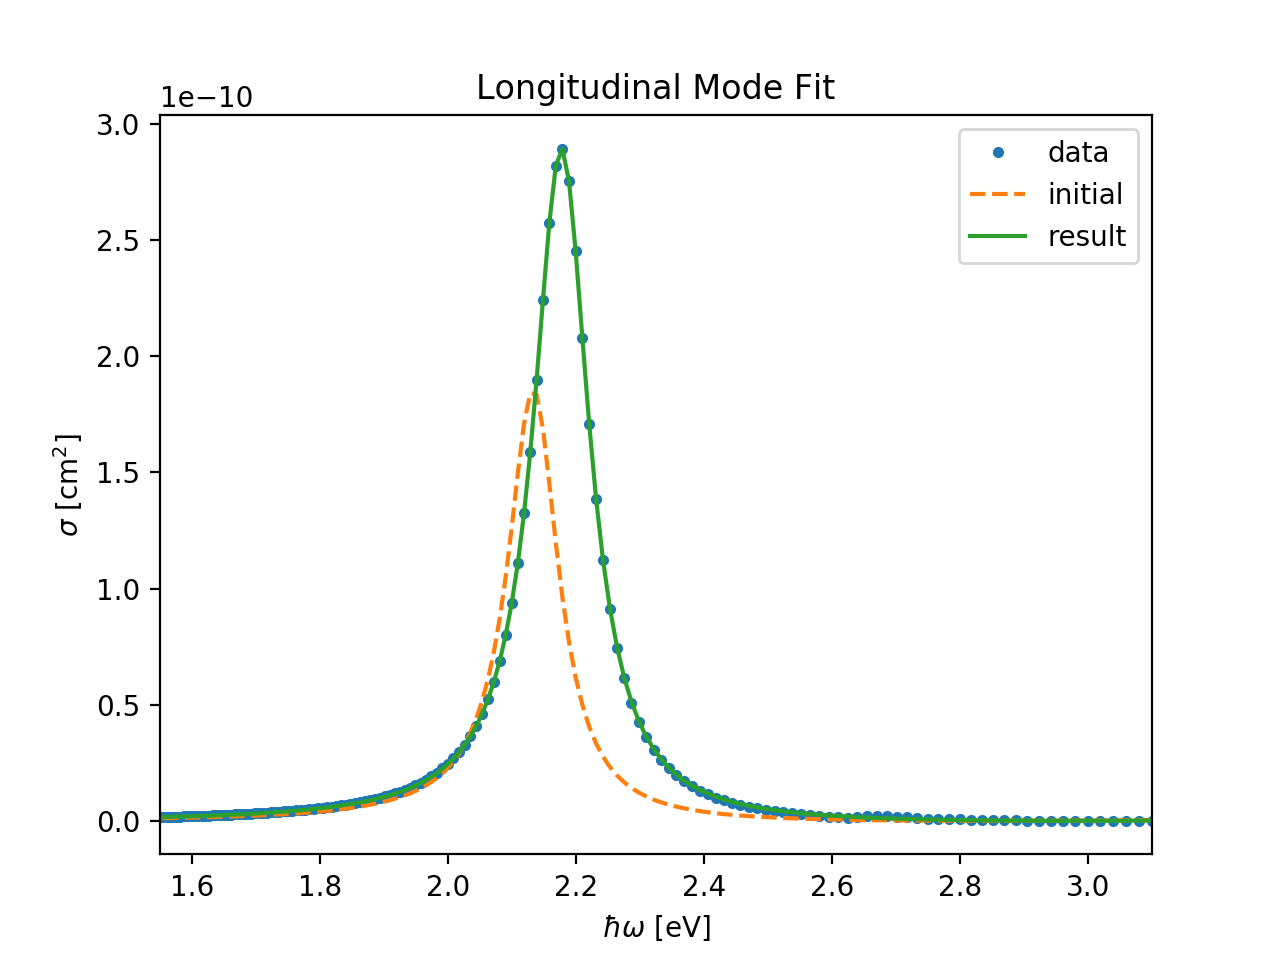

<IPython.core.display.Javascript object>


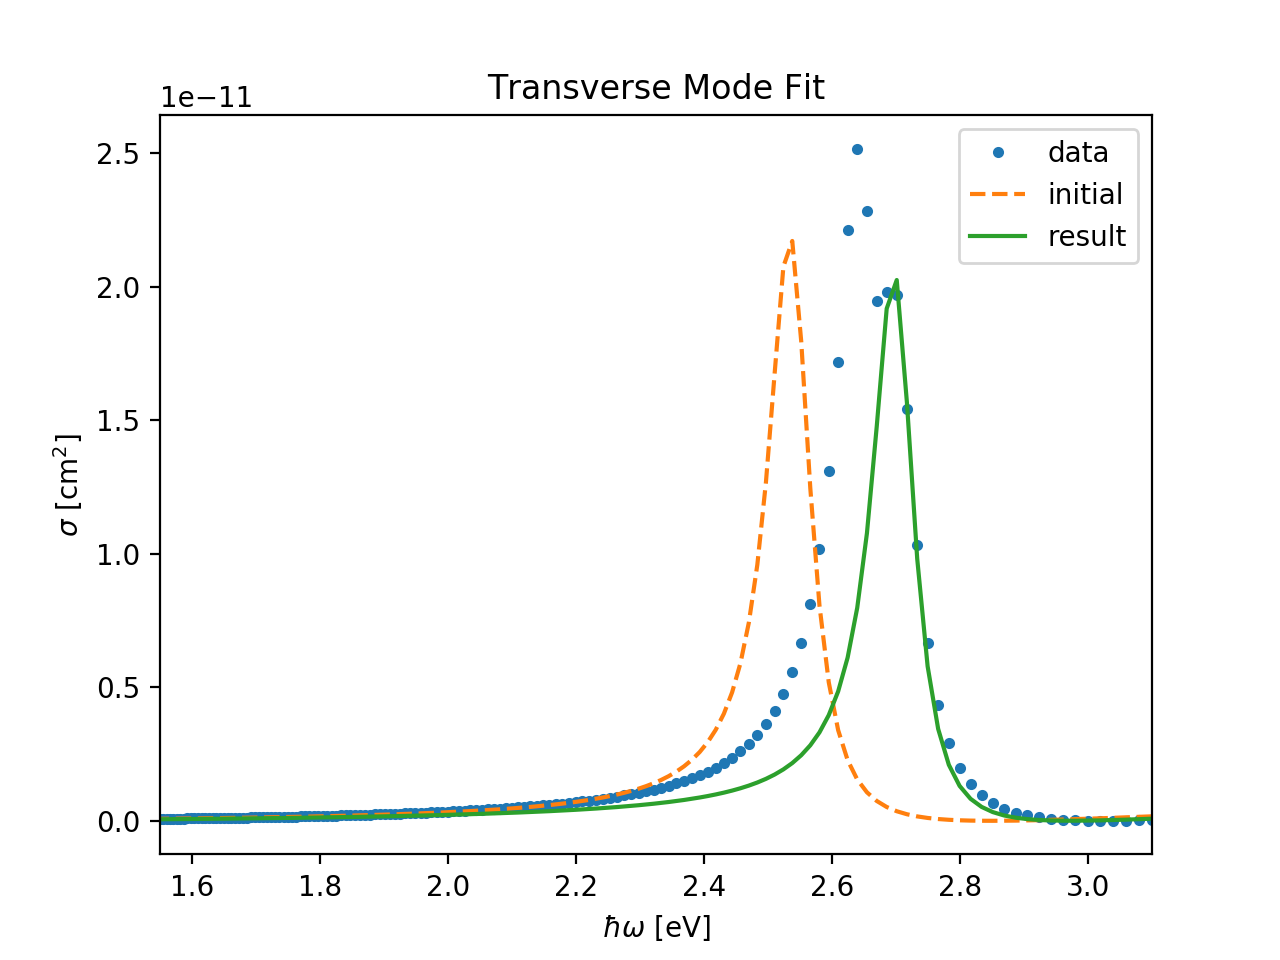

In [126]:
plt.figure(dpi=100)
plt.plot(long_hbarws, long_sigma, label='data', ls=' ', marker='.')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *ini_guess_both)*1e-10,label='initial', ls='--')
plt.plot(long_hbarws, ret_fit_scat_1(long_hbarws, *no_trans_quad_result['x'])*1e-10,label='result', ls='-')
plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Longitudinal Mode Fit')
plt.legend()

plt.figure(dpi=100)
plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both)*1e-10, label='initial', ls='--')
plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *no_trans_quad_result['x'])*1e-10, label='result', ls='-')
plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Transverse Mode Fit')
plt.legend()

In [127]:
dict(zip(param_str_list, no_trans_quad_result['x']))


{'eps_inf': 12.908326291263885,
 'hbarw_p': 10.248647965010242,
 'hbargamma': 0.06809893154023487,
 'a_1': 49.23668672036996,
 'a_2': 18.510953331428315}

No, thats even worse, which is good. It must just be coincidental that fitting the double peak yields closer drude parameters. I will assum remaining error is dies to the rod not truly being a prolate ellipsoid. 